# PARSER: A model for word segmentation
## Experimentation

Importing of data and folders

In [1]:
import sys
import os
import random
from pathlib import Path
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
py.init_notebook_mode(connected=True) 

root_folder = Path(os.getcwd())
PARSER_folder = os.path.join(root_folder.parent,"PARSER")
sys.path.append(PARSER_folder)

import data_handeling as dh
from PARSER_class import PARSER

data_folder = os.path.join(root_folder.parent,"Data")

Before we start the experiments. We define a number function that will be used for simply runing experiments, and to analyse experiments. 

**run_experiment:**  
- Arguments
        1) a set of exposure strings. 
        2) The number of items the model is to  be trained on.  
        3) Any number of categories of test-strings. 
- returns the number of correctly identified strings for each testing category. in the form of a dictionary: {'category_name':correct} 

**run_multiple_experiments**
- Arguments
        1) a set of exposure strings. 
        2) The number of items the model is to  be trained on.  
        3) Any number of categories of test-strings. 
        4) The number of experiments to be simulated
- returns a list of results as they are produced in the run_experiment function 

**analyse_data**
- Arguments
        1) results from either run_experiment or run_multiple_experiments
        2) The testing data

**If the model is attempting to detect the number of consistent strings then:**
    * True positive  = A consistent string is classified as consistent
	* False positive = A violating string classified as consistent
	* True negative  = A violating string classified as violating
	* False negative = A consistent string classified as violating 

**Otherwise**

    * True positive  = A violating string is classified as violating
	* False positive = A consistent string classified as violating
	* True negative  = A consistent string classified as consistent
	* False negative = A violating string classified as consistent 
        
- Returns a dictionary with various measurements 




In [2]:
# Here it is all defined in a function for easier testability:
def run_experiment(exposure_strings,nr_of_strings, test_data, stimuli = 
                    None, random_seed = None,print_output = False, detect_violation = False, get_failed = False):
    if stimuli is None:
        stimuli = dh.generate_stimuli(exposure_strings, nr_of_strings, random_seed=random_seed)
    primitives = set(stimuli)
    model = PARSER(primitives = primitives,random_seed=random_seed)
    # We then feed the model the generated stimuli. 
    model.percept_shaper = {} #This is a safety mechanism for making sure that each run is reset.
    model.run_til_end(stimuli)
    results = {}
    for category_name, testing_strings in test_data.items(): 
        if print_output: print("Testing category:", category_name)
        correct_implicit = model.test_implicit(testing_strings, print_output= print_output,
                                               detect_violation = detect_violation, get_failed = get_failed)
        results[category_name] = correct_implicit
    return results

def run_multiple_experiments(exposure_strings,nr_of_strings, test_data,nr_of_experiments, 
                             stimuli = None, random_seed = None,print_output = False,detect_violation = False):
    results = []
    if stimuli is None:
        stimuli = dh.generate_stimuli(exposure_strings, nr_of_strings, random_seed=random_seed)
    for count in range(0,nr_of_experiments):
        results.append(run_experiment(exposure_strings, nr_of_strings, test_data,stimuli = stimuli, 
                                random_seed = random_seed,print_output = print_output, detect_violation=detect_violation))
    return results    

def analyse_multiple_models(results, names_consistent, names_violating, 
                                      test_data,detect_violation= False):
    analyzed_models = {}
    average_model = {}
    for count, result in enumerate(results):
        analyzed_models[str(count)] = analyse_single_model(result, names_consistent, names_violating, test_data, 
                                                    detect_violation= detect_violation)
        
        for measurement, value in analyzed_models[str(count)].items():
            if measurement not in average_model:
                average_model[measurement] = value
            else: 
                if measurement != 'total_population':
                    average_model[measurement] += value
    temp_save = average_model['total_population']
    average_model = {measurement:value/len(results) for measurement,value in average_model.items() if measurement != 'total_population'}
    average_model['total_population'] = temp_save
    

    return analyzed_models, average_model
 

def analyse_single_model(results, names_consistent, names_violating, 
                                      test_data,detect_violation= False):
    if type(results)== list:
        results = results[0]
    
    res_index= 0

    len_violating = sum([len(test_data[name]) for name in names_violating])
    len_consistent = sum([len(test_data[name]) for name in names_consistent])
    total_population = len_violating + len_consistent

    if detect_violation:
        tp = sum([results[name] for name in names_violating])
        fp = sum([results[name] for name in names_consistent])
        tn = len_consistent-fp
        fn = len_violating-tp
    else:
        tp = sum([results[name] for name in names_consistent])
        fp = sum([results[name] for name in names_violating])
        tn = len_violating-fp
        fn = len_consistent-tp
        
    
    accuracy = (tp + tn)/total_population
    precision = float('NaN') if (tp == 0) and (fp==0) else tp/(tp+fp) 
    recall = float('NaN') if (tp == 0) and (fn==0) else tp/(tp+fn) #Also known as TPR, True positive rate
    specificity  = float('Nan') if (tp == 0) and (fp == 0) else tn/(tn + fp)
    f1_score = 2 * ((precision*recall)/(precision+recall))
    
    return {'tp':tp,
            'fp':fp,
            'tn':tn,
            'fn':fn,
            'accuracy':accuracy,
            'precision':precision,
            'recall':recall,
            'specificity':specificity,
            'f1':f1_score,
            'total_population':{'Consistent':len_consistent, 'Violating':len_violating}}

def temp_mean():
       #{'Violating': 7, 'Consistent': 0}
    #Get the mean 
    mean = {}
    for result in results:
        for category,cat_res in result.items():
            if category+'_explicit' in mean:
                mean[category+'_explicit'] += cat_res[0]
                mean[category+'_implicit'] += cat_res[1]
            else:
                mean[category+'_explicit'] = cat_res[0]
                mean[category+'_implicit'] = cat_res[1]
                    
    mean = {name:(added/len(results),len(test_data.get(name[:-9]))) for name,added in mean.items()}
    return mean

In [3]:
def plot_analyzed_data(analyzed_models):
    data = pd.DataFrame.from_dict(analyzed_models).transpose()
    accuracy_data = data['accuracy'].values.tolist()
    precision_data = data['precision'].values.tolist()
    recall_data = data['recall'].values.tolist()

    accuracy = go.Box(
        y=accuracy_data,
        name = 'Accuracy',
        boxmean=True,
        boxpoints=False,
        jitter=0.3,
    )
    precision = go.Box(
        y=precision_data,
        name = 'Precision',
        boxmean=True,
        boxpoints=False,
        jitter=0.3,
    )
    recall = go.Box(
        y=recall_data,
        name = 'Recall',
        boxmean=True,
        boxpoints=False,
        jitter=0.3,
    )

    layout = go.Layout(
        width=500,
        yaxis=dict(
            title='%',
            zeroline=False
        ),
    )

    data = [accuracy,precision,recall]
    fig= go.Figure(data=data, layout=layout)
    py.offline.iplot(fig, filename='Accuracy-box-plot')
    #return data
    
def make_confusion_matrix(models):
    data = pd.DataFrame.from_dict(models).transpose()
    tp = np.mean(data['tp'].values.tolist())
    tn = np.mean(data['tn'].values.tolist())
    fp = np.mean(data['fp'].values.tolist())
    fn = np.mean(data['fn'].values.tolist())
    nr_viol = data['total_population'].get('1').get('Violating')
    nr_con = data['total_population'].get('1').get('Consistent')
    z = [[fn,tn],[tp,fp]]
    x = ['Violating ('+str(nr_viol)+')', 'Consistent('+str(nr_con)+')']
    y = ['Consistent('+str(nr_con)+')','Violating('+str(nr_viol)+')']
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z, colorscale='Viridis')
    #ata = [trace] 
    py.iplot(fig, filename = 'basic_table')
    


***

## Experiment 1

### EEG potentials associated with artifical gramamr learning in the primate brain. 


##### Attaheri A, Kikuchi Y, Milne AE, Wilson B, Alter K, Petkov CI (2015), Brain and Language 148:74–80.
In this paper a study is described where they record EEG potentials during an auditory AG learning experiment in two Rhesus macaques. The two monkeys were first exposed to sequences consistent with a AG, and then tested on sequences that were consistent, and sequences that were violating. 

**Results in the study:** 
The study shows that certain ERP components were modulated to a greater extent when there was a when the stimuli contained a violation then when it did not. It is claimed in the paper that this study, as well as a behaviroual study using eye-tracking cannot be explained by simple learning strategies.  
***


### Goal of replicating experiment:
**Quantitative goal:**
The goal here is to first and foremost show that the sequences can be learnd by a simple learning strategy, such as PARSER. A machine-learning approach to model evaluation is taken in this step. 
    The hypothesis is that the average PARSER model will be able to distingush between grammatical and violating strings at a level higher than chance. 

**Qualitative goal**
Another goal for this experiment is to show the relation between the ERPs in the study and where the model makes the choice of the string not being consistent. Showing that the model does react to the predicted violations in the stimuli. 

***

### Translating the experiment procedure in the paper:

**Stimuli:** 
Three string categories (Exposure, violating and consistent). All strings in the exposure and consistent sets were created using the artifcial grammar depicted in the image below. The violating set consisted of strings with illegal transitions. 

**Exposure:** 
Macaques were exposed to the exemplary AG sequences for 30 minutes. Presenting one intem consists of 3 pahses. A 500ms fixation, 2665ms sequence presentation and a > 4500 ms of inter trial interval. This results in a total of 7.6 seconds per trial, here we round this up to 8 seconds. 
Since there is 8 seconds per trial, exposure happens for 30 minutes, that gives us a total of (60/8)*30 = 225 items to train the model on. Every string is randomly selected from the set of exposure strings, string repititions are allowed.

**Evaluation:**
This experiment is looking for ERPs in regard to violating strings, they assume that they are "classified" as consistent in the event that there either a missing or a lowered ERP response. Therefore, in this scenario, a true positive is a string that has been correctly classified as a violating string. 



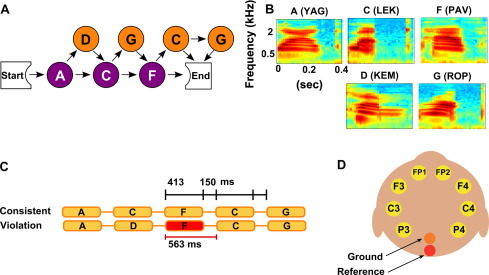

In [4]:
# First we get the stringsets from the dataset
attaheri_2015 = "attaherietal_brainlanguage_2015.yaml"
attaheri_2015_strings = dh.get_paper_data(data_folder, attaheri_2015)

In [5]:
attaheri_nr_of_strings = 225
attaheri_2015_exposure = attaheri_2015_strings['Exposure']
testing_categories = ['Violating','Consistent']
attaheri_2015_testing = {name:list(set(attaheri_2015_strings[name])) for name in testing_categories}

### Quantative goal:
**Procedure**
1. Genereate a stimuli string
2. Train X number of models on the string. X = 1000
3. Analyze the performance of all models. 
4. Conclude if the model on average learns to distingush between consistent and violating strings. 


In [6]:
# 1. Genereate a stimuli string
attaheri_stimuli = dh.generate_stimuli(attaheri_2015_exposure, attaheri_nr_of_strings)
# 2. Train 1000 models on the stimuli string, and test them on their ability to detect violating strings. 
attaheri_detect_violation = True
attaheri_number_of_models= 100
attaheri_results = run_multiple_experiments(attaheri_2015_exposure, attaheri_nr_of_strings,attaheri_2015_testing,attaheri_number_of_models, stimuli = attaheri_stimuli, detect_violation=attaheri_detect_violation)
# 3. Analyze the performance of all models. 
attaheri_analyzed_models, attaheri_average_model = analyse_multiple_models(attaheri_results,['Consistent'],['Violating'],attaheri_2015_testing, detect_violation=attaheri_detect_violation)
attaheri_average_model

{'tp': 7.2,
 'fp': 1.43,
 'tn': 2.57,
 'fn': 0.8,
 'accuracy': 0.8141666666666668,
 'precision': 0.860010101010101,
 'recall': 0.9,
 'specificity': 0.6425,
 'f1': 0.8713925008599926,
 'total_population': {'Consistent': 4, 'Violating': 8}}

In [7]:
if 'numpy' in sys.modules:
    plot_analyzed_data(attaheri_analyzed_models)

In [10]:
if 'numpy' in sys.modules:
    make_confusion_matrix(attaheri_analyzed_models)

**4. Conclusion** 
The accuracy of the model ranges from 60% and up to 91%. And the average accuracy performance is about 80 %. This is well above chance and shows that the model is sensetive to the detection of violating strings. 
***


### Qualitative goal:
**Procedure**
Investigate whether a learnt models response is similar to the ERP curves of

1. Genereate a stimuli string (Use a random-seed so it can be replicated)
2. Train a single model on the string. (Use random-seed so it can be replicated)
3. Test the model, having printing of results on. 
4. Show that the model does react to the same as what is thought the ERPs are reactions to



In [8]:
# 1. Genereate a stimuli string
random_seed = 762
attaheri_stimuli_2 = dh.generate_stimuli(attaheri_2015_exposure,attaheri_nr_of_strings, random_seed = random_seed)
primitives_goal2 = set(attaheri_stimuli_2)
model_goal2 = PARSER(primitives = primitives_goal2,random_seed=random_seed)
model_goal2.percept_shaper = {} #This is a safety mechanism for making sure that each run is reset.
model_goal2.run_til_end(attaheri_stimuli_2)

results_goal2 =[[],[],[]]
for category,test_input in attaheri_2015_testing.items():
    for test_string in test_input:
        violation, completed, failed = model_goal2.test_implicit(test_string,print_output=False,detect_violation = attaheri_detect_violation, get_failed = True)
        if violation:
            results_goal2[0].append([test_string])
            results_goal2[1].append([completed])
            results_goal2[2].append([failed])

attaheri_results = run_experiment(attaheri_2015_exposure,0,attaheri_2015_testing, stimuli = attaheri_stimuli_2,
                                    random_seed = random_seed, detect_violation=attaheri_detect_violation, print_output=True, get_failed = True)
trace = go.Table(
    header=dict(values=['Word', 'Completed','Failed']),
    cells=dict(values=results_goal2))

print(results_goal2)
data = [trace] 
py.iplot(data, filename = 'basic_table')



Testing category: Violating
agcfc 	 is VIOLATING: [][]cfc , failed to match [ag][gc]
adfcg 	 is VIOLATING: a[]fcg , failed to match [df]
afcgc 	 is VIOLATING: []fc[] , failed to match [af][gc]
adgfc 	 is VIOLATING: a[]gfc , failed to match [dg]
agfcd 	 is VIOLATING: []gf[] , failed to match [ag][cd]
acfcf 	 is CONSISTENT: acfcf
adcgc 	 is VIOLATING: adc[] , failed to match [gc]
acdfc 	 is VIOLATING: a[][]fc , failed to match [cd][df]
Testing category: Consistent
adcfc 	 is CONSISTENT: adcfc
acfcg 	 is CONSISTENT: acfcg
acgfc 	 is CONSISTENT: acgfc
adcgf 	 is CONSISTENT: adcgf
[[['agcfc'], ['adfcg'], ['afcgc'], ['adgfc'], ['agfcd'], ['adcgc'], ['acdfc']], [['[][]cfc'], ['a[]fcg'], ['[]fc[]'], ['a[]gfc'], ['[]gf[]'], ['adc[]'], ['a[][]fc']], [['[ag][gc]'], ['[df]'], ['[af][gc]'], ['[dg]'], ['[ag][cd]'], ['[gc]'], ['[cd][df]']]]


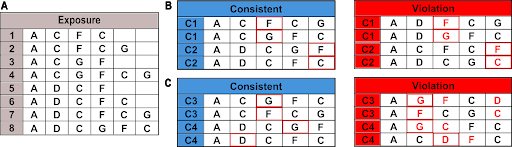

This image shows the illegal transitions in the "violation" string set. 
If the model is classifying a string a violation, it does so because it is not able to match a certain string. In other words, this means that the model is expecting something different in its place. As we can see above, the first string "adfcg" is classified as a violating string because it did not expect/failed to match the sequence "df". The model is therefore able to predict when in the string the expected difference in the ERP would occur. 
It would be very interesting to get access to the response behviour for individual string recordings as then we could compare them to the model-results as shown above. 
If a single recording could would yield little or no difference in ERPs when presented with the "acfcf" string (which is the only false-negative in the data above), it could potentially show that the monkeys are not able to learn the cyclic nature of the grammar they were presented. 

***

Experiment 2
=======
***

### Rule learning by zebra finches in an artificial grammar learning task: which rule? 


##### Heijningen CAA van, Chen J, Laatum I van, Hulst B van der, Cate C ten (2013)  Anim Cogn 16:165–175.
Using the AGL paradigme zebrafinshes were tested in a Go/No-Go experiment for their ability to distinguish structurally different three-element sound sequences. 
**Probe experiment 1:**
This experiment examined whether zebra finches are able to discriminate three-element stimuli with an XYX structure (ABA and BAB–Go stimuli) from stimuli with an XXY or YXX structure (BAA, AAB, BAA, and ABB–No-go stimuli) and, in particular, addressed the question how the birds solved the task. To test how suggested hypothesises on how the birds did solve this task, the tested/probed the birds using two probe-string-sets with specific rules. 

**Probe experiment 2:**
Experiment 2 was an extention of experiment 1, where the extended the training set and the presence or absence of repetitions vould no longer be used to discriminate between sets. 

**Results from probe experiment 1 and 2 in the study:** 
The study demonstrate that zebra finches can learn to discriminate ABA, BAB from BBa, BAA, ABB and AAb. The discrimination may suggest that the birds obtained some insight in the abstract rules differentiating the stimulus sets. 


***


### Goal of replicating experiment:
**Quantitative goal:**
In the paper it is claimes that the learn rules. By having a replication of this experiment using a model based on chunking we show that rule-learning might not be involved at all. 


***

### Translating the experiment procedure in the paper:

**Stimuli:** 
There are 

**Exposure:** 


**Evaluation:**
For the training phase we here argue that to get food the birds learn to identify grammatical strings, while to not get shocked they learn to identify violating strings. This means that for the training phase until they reach the peformance critera which is prefered, they will learn to

A Go repsone is if a Go-string is classified as Consistent, and a No-Go response is when a NoGo-string is classified as Vioalting. We want to reach either a >75 % Go response on Go strings and <25% Go responses when hearing a NoGo String. 


In [9]:
# First we get the stringsets from the dataset
vanheijningen = "vanheijningenetal_animcogn_2013.yaml"
vanheijningen_strings = dh.get_paper_data(data_folder, vanheijningen)

In [11]:
vanheijningen_nr_of_strings = 225
vanheijningen_exposure = vanheijningen_strings['Experiment_1_Go']
vanheijningen_testing_categories = ['Experiment_1_Go','Experiment_1_NoGo']
vanheijningen_probe_categories = ['Experiment_1_probeset_1','Experiment_1_probeset_2']
vanheijningen_testing = {name:list(set(vanheijningen_strings[name])) for name in vanheijningen_testing_categories}
vanheijningen_probing = {name:list(set(vanheijningen_strings[name])) for name in vanheijningen_probe_categories}

In [12]:
def vanheijningen_training(model, exposure, testing_data, print_out=False, seed = None):
    # Make a random number generator for reproducability
    if seed is None: 
        rnd = random.Random(seed)
    else:
        rnd = random.Random(seed)
    go = 0
    noGo = 0
    count = 0
    while (count < 300 or (noGo < 75 and go < 75)):
        # Get another string. 
        stimuli = exposure[rnd.randrange(len(exposure))]
        # Feed it to the model
        model.run_til_end(stimuli)
        # Check go and noGo stats. 
        if print_out: print("Go:")
        go_res = model.test_implicit(testing_data['Experiment_1_Go'], detect_violation = False, print_output= print_out)
        if print_out: print("NoGo:")
        noGo_res = model.test_implicit(testing_data['Experiment_1_NoGo'], detect_violation = True,print_output= print_out)
        go = (go_res/len(testing_data['Experiment_1_Go']))*100
        noGo = (noGo_res/len(testing_data['Experiment_1_NoGo']))*100
        if print_out: print(go, noGo)
        count +=1
    return model
        
vanheijningen_po = False

# Not all models are actually capable of learning this sequence. Some do, some don't.
# Therefore, we set a random seed known to reach the criterions. 

nr_of_birds = 8
vanheijningen_results_1 = []
vanheijningen_results_2 = []
vanheijningen_parameters = PARSER.get_default_parameters()
# NEED TO JUSTIFY THIS!!!! 
vanheijningen_parameters['max_percept_size'] = 2
vanheijningen_parameters['forgetting_weight'] = -0.1
vanheijningen_parameters['interference_weight'] = -0.01
for i in range(nr_of_birds):    
    seed =random.randrange(sys.maxsize)
    rnd = random.Random(seed)
    # Initialize model. 
    vanheijningen_primitives = ['A','B','C']
    vanheijningen_model = PARSER(primitives = vanheijningen_primitives, parameters=vanheijningen_parameters, random_seed=seed)
    # First make the model reach the criterion on day 1
    vanheijningen_model = vanheijningen_training(vanheijningen_model, vanheijningen_exposure, vanheijningen_testing, print_out=vanheijningen_po,seed = seed)
    # Then make the model show that be able to keep the criterion up.
    # To do so we keep training the model until it can once again prove itself, this qualifies as day 2. 
    vanheijningen_model = vanheijningen_training(vanheijningen_model, vanheijningen_exposure, vanheijningen_testing, print_out=vanheijningen_po, seed = seed)
    go_test= vanheijningen_model.test_implicit(vanheijningen_testing['Experiment_1_Go'], print_output=vanheijningen_po)
    # Make list of 50 elements that has probe sequences in it adn 20% familiar strings
    probe_set_1 = vanheijningen_exposure + vanheijningen_testing['Experiment_1_NoGo']
    # Then we add 10 of each of the elemnts from the probset in there. 
    probe_set_1.extend(vanheijningen_probing['Experiment_1_probeset_1']*8)
    # Every item is at least presented 40 times. 8 in the set already, times 5 = 40
    probe_set_1 = probe_set_1*5
    # Shuffle the probeset
    rnd.shuffle(probe_set_1)
    # Then we train the model by letting it get the every string in the probeset
    #print(vanheijningen_model.percept_shaper)

    results_prob_one = {}
    # For every stimulus string in the probeset
    for stimuli in probe_set_1:
        # Train the model on that string, meaning the full string has been percieved, not care about how many perception cycles
        vanheijningen_model.run_til_end(stimuli)
        # Then test the model on the same string
        test_res = vanheijningen_model.test_implicit(stimuli)
        # If the stimulus is already in the results
        if stimuli in results_prob_one:
            # Then add the result from this string, which is either a True or False
            results_prob_one[stimuli].append(test_res)
        else: 
            # Otherwise add it to the dictionary. 
            results_prob_one[stimuli] = [test_res]
    # Then add each "bird"'s results to another dictionary 
    vanheijningen_results_1.append(results_prob_one)    
    
    # Probeset 2 have only negative trainign stimuli in it
    probe_set_2 = vanheijningen_exposure +vanheijningen_testing['Experiment_1_NoGo']
    probe_set_2.extend(vanheijningen_probing['Experiment_1_probeset_2']*8)
      # Every item is at least presented 40 times. 8 in the set already, times 5 = 40
    probe_set_2 = probe_set_2*5
    # Shuffle the probeset
    rnd.shuffle(probe_set_2)
    
    results_prob_two = {}
    # For every stimulus string in the probeset
    for stimuli in probe_set_2:
        # Train the model on that string, meaning the full string has been percieved, not care about how many perception cycles
        vanheijningen_model.run_til_end(stimuli)
        # Then test the model on the same string
        test_res = vanheijningen_model.test_implicit(stimuli)
        # If the stimulus is already in the results
        if stimuli in results_prob_two:
            # Then add the result from this string, which is either a True or False
            results_prob_two[stimuli].append(test_res)
        else: 
             # Otherwise add it to the dictionary. 
            results_prob_two[stimuli] = [test_res]
     # Then add each "bird"'s results to another dictionary
    vanheijningen_results_2.append(results_prob_two)

vanheijningen_counts_1 = {}
vanheijningen_counts_2 = {}

for index, bird in enumerate(vanheijningen_results_1):
    vanheijningen_counts_1[index] = {name:(sum([1 for x in res if x])/len(res))*100 for name,res in bird.items()}
for index, bird in enumerate(vanheijningen_results_2):
    vanheijningen_counts_2[index] = {name:(sum([1 for x in res if x])/len(res))*100 for name,res in bird.items()}
    
    

In [13]:
vanheijningen_data_1 = pd.DataFrame.from_dict(vanheijningen_counts_1).transpose()
vanheijningen_data_2 = pd.DataFrame.from_dict(vanheijningen_counts_2).transpose()
v_plot_data_1 ={entry:np.mean(vanheijningen_data_1[entry].values.tolist()) for entry in vanheijningen_data_1}
v_plot_data_2 ={entry:np.mean(vanheijningen_data_2[entry].values.tolist()) for entry in vanheijningen_data_2}
# Now lets group it together as is shown in Fig.2.a in the paper
# Groups: [ABA,BAB],[BBA,AAB,BAA,ABB],[ACA,CAC],[ABBA,BAAB]
vanheijningen_x_1 = ["ABA,BAB","BBA,AAB,BAA,ABB","ACA,CAC","ABBA,BAAB"] 
vanheijningen_y_1 = [(v_plot_data_1['ABA']+v_plot_data_1['BAB'])/2,
                    (v_plot_data_1['BBA']+v_plot_data_1['AAB']+v_plot_data_1['BAA']+v_plot_data_1['ABB'])/4,
                    (v_plot_data_1['ACA']+v_plot_data_1['CAC'])/2,
                    (v_plot_data_1['ABBA']+v_plot_data_1['BAAB'])/2]

vanheijningen_x_2 = ["ABA,BAB","BBA,AAB,BAA,ABB","ABAB,BABA","AABB,BBAA"] 
vanheijningen_y_2 = [(v_plot_data_2['ABA']+v_plot_data_2['BAB'])/2,
                    (v_plot_data_2['BBA']+v_plot_data_2['AAB']+v_plot_data_2['BAA']+v_plot_data_2['ABB'])/4,
                    (v_plot_data_2['ABAB']+v_plot_data_2['BABA'])/2,
                    (v_plot_data_2['AABB']+v_plot_data_2['BBAA'])/2]
#
vanheijningen_plot_data_1 =[go.Bar(
                            x = vanheijningen_x_1,
                            y = vanheijningen_y_1)]

vanheijningen_plot_data_2 =[go.Bar(
                            x = vanheijningen_x_2,
                            y = vanheijningen_y_2)]

vanheijningen_layout_1 = go.Layout(
    title='Probeset 1',
    xaxis=dict(
        title='Stimulus',
         titlefont=dict(
            size=18,
        ),
        tickfont=dict(
            size=18
        )
    ),
    yaxis=dict(
        title='Probability of response',
        titlefont=dict(
            size=18,
        )
    )
)
vanheijningen_layout_2 = go.Layout(
    title='Probeset 2',
    xaxis=dict(
        title='Stimulus',
         titlefont=dict(
            size=18,
        ),
        tickfont=dict(
            size=15
        )
    ),
    yaxis=dict(
        title='Probability of response',
        titlefont=dict(
            size=18,
        )
    )
)


fig_1= go.Figure(data=vanheijningen_plot_data_1, layout = vanheijningen_layout_1)
fig_2= go.Figure(data=vanheijningen_plot_data_2, layout = vanheijningen_layout_2)

py.offline.iplot(fig_1, filename='Experiment 1-plot')
py.offline.iplot(fig_2, filename='Experiment 2-plot')

# Other expierments.
## The experiments below are not studies beign replicated in detail, but only experiments to see what string-sets PARSER can learn

String learning experiment 1
=======
***

### Auditory sequence processing reveals evolutionarily conserved regions of frontal cortex in macaques and humans.

##### Wilson B, Kikuchi Y, Sun L, Hunter D, Dick F,  Smith K, Thiele A, Griffiths TD, Marslen-Wilson WD, Petkov CI (2015)
**Abstract:** An evolutionary account of human language as a neurobiological system must distinguish between human-unique neurocognitive processes supporting language and evolutionarily conserved, domain-general processes that can be traced back to our primate ancestors. Neuroimaging studies across species may determine whether candidate neural processes are supported by homologous, functionally conserved brain areas or by different neurobiological substrates. Here we use functional magnetic resonance imaging in Rhesus macaques and humans to examine the brain regions involved in processing the ordering relationships between auditory nonsense words in rule-based sequences. We find that key regions in the human ventral frontal and opercular cortex have functional counterparts in the monkey brain. These regions are also known to be associated with initial stages of human syntactic processing. This study raises the possibility that certain ventral frontal neural systems, which play a significant role in language function in modern humans, originally evolved to support domain-general abilities involved in sequence processing.

In [14]:
wilsonetal = "wilsonetal_natcomm_2015.yaml"
wilsonetal_strings = dh.get_paper_data(data_folder, wilsonetal)
wilsonetal_primitives = dh.get_paper_primitives(data_folder, wilsonetal)
wilsonetal_exposure = wilsonetal_strings['Exposure']
wilsonetal_testing_categories = ['CorrectTest','ViolatingTest']
wilsonetal_testing = {name:list(set(wilsonetal_strings[name])) for name in wilsonetal_testing_categories}

wilsonetal_nr_of_strings = 400
wilsonetal_nr_of_models = 1000
wilsonetal_parameters = PARSER.get_default_parameters()

wilsonetal_multiple_runs = run_multiple_experiments(wilsonetal_exposure,wilsonetal_nr_of_strings, wilsonetal_testing,wilsonetal_nr_of_models,detect_violation=True)
wilsonetal_analyzed_models, wilsonetal_average_model = analyse_multiple_models(wilsonetal_multiple_runs,['CorrectTest'],['ViolatingTest'],wilsonetal_testing, detect_violation=True)
make_confusion_matrix(wilsonetal_analyzed_models)

In [ ]:
plot_analyzed_data(wilsonetal_analyzed_models)

String learning experiment 2
=======
***

### Mixed‐complexity artificial grammar learning in humans and macaque monkeys: evaluating learning strategies

#####  Wilson B, Smith K, Petkov CI (2015)
**Abstract:** Here, we tested humans and Rhesus macaques using a mixed-complexity auditory AG, containing both adjacent (local) and non-adjacent (longer-distance) relationships. Following exposure to exemplary sequences generated by the AG, humans and macaques were individually tested with sequences that were either consistent with the AG or violated specific adjacent or non-adjacent relationships. We observed a considerable level of cross-species correspondence in the sensitivity of both humans and macaques to the adjacent AG relationships and to the statistical properties of the sequences. We found no significant sensitivity to the non-adjacentn AG relationships in the macaques. A subset of humans was sensitive to this non adjacent relationship, revealing interesting between- and within-species differences in AG learning strategies. The results suggest that humans and macaques are largely comparably sensitive to the adjacent AG relationships and their statistical properties. However, in the presence of multiple cues to grammaticality, the non-adjacent relationships are less salient to the macaques and many of the humans.


In [18]:
wilsonetal_ejn = "wilsonetal_ejn_2015.yaml"
wilsonetal_ejn_strings = dh.get_paper_data(data_folder, wilsonetal_ejn)
wilsonetal_ejn_primitives = dh.get_paper_primitives(data_folder, wilsonetal_ejn)
wilsonetal_ejn_exposure = wilsonetal_ejn_strings['Exposure']
wilsonetal_ejn_testing_categories = ['CorrectTest','ViolationTest']
wilsonetal_ejn_testing = {name:list(set(wilsonetal_ejn_strings[name])) for name in wilsonetal_ejn_testing_categories}

wilsonetal_ejn_nr_of_strings = 400
wilsonetal_ejn_nr_of_models = 1000
wilsonetal_ejn_parameters = PARSER.get_default_parameters()

wilsonetal_ejn_multiple_runs = run_multiple_experiments(wilsonetal_ejn_exposure,wilsonetal_ejn_nr_of_strings, wilsonetal_ejn_testing,wilsonetal_ejn_nr_of_models, detect_violation=True)
wilsonetal_ejn_analyzed_models, wilsonetal_ejn_average_model = analyse_multiple_models(wilsonetal_ejn_multiple_runs,['CorrectTest'],['ViolationTest'],wilsonetal_ejn_testing,detect_violation=True)
make_confusion_matrix(wilsonetal_ejn_analyzed_models)
wilsonetal_ejn_average_model

{'tp': 8.0,
 'fp': 0.742,
 'tn': 3.258,
 'fn': 0.0,
 'accuracy': 0.9381666666666699,
 'precision': 0.9298363636363594,
 'recall': 1.0,
 'specificity': 0.8145,
 'f1': 0.9601111111111154,
 'total_population': {'Consistent': 4, 'Violating': 8}}

In [19]:
plot_analyzed_data(wilsonetal_ejn_analyzed_models)

String learning experiment 3
=======
***

### Auditory Artificial Grammar Learning in Macaque and Marmoset Monkeys.

##### Wilson B, Slater H, Kikuchi Y, Milne AE, Marslen-Wilson WD, Smith K, Petkov CI (2013)
**Abstract:** We developed a simple quantitative parameter space, which we used to summarize previous nonhuman animal AGL results. This was usedto highlight an under-studied AG with aforward-branching structure, designed to model certain aspects of the nondeterministic nature of word transitions in natural language and animal song. We tested whether two monkey species could learn aspects of this auditory AG. After habituating the monkeys to the AG, analysis of video recordings showed that common marmosets (New World monkeys) differentiated between well formed, correct testing sequences and those violatingthe AG structure based primarily on simple learning strategies. By comparison, Rhesus macaques  OldWorld monkeys) showed evidence for deeper levels of AGL. A novel eye-tracking approach confirmed this result in the macaques and demonstrated evidence for more complex AGL. This study provides evidence for a previously unknown level of AGL complexity in Old World monkeys that seems less evident in New World monkeys, which are more distant evolutionary relatives to humans. The findings allow for the development of both marmosets and macaques as neurobiological model systems to study different aspects of AGL at the neuronal level.


In [15]:
wilsonetal_jn = "wilsonetal_jneurosci_2013.yaml"
wilsonetal_jn_strings = dh.get_paper_data(data_folder, wilsonetal_jn)
wilsonetal_jn_primitives = dh.get_paper_primitives(data_folder, wilsonetal_jn)
wilsonetal_jn_exposure = wilsonetal_jn_strings['Hab']
wilsonetal_jn_testing_categories = ['Fam','Novel','ViolbA','ViolnbA']
wilsonetal_jn_testing = {name:list(set(wilsonetal_jn_strings[name])) for name in wilsonetal_jn_testing_categories}

wilsonetal_jn_nr_of_strings = 400
wilsonetal_jn_nr_of_models = 1000
wilsonetal_jn_parameters = PARSER.get_default_parameters()

wilsonetal_jn_multiple_runs = run_multiple_experiments(wilsonetal_jn_exposure,wilsonetal_jn_nr_of_strings, wilsonetal_jn_testing,wilsonetal_jn_nr_of_models, detect_violation=True)
wilsonetal_jn_analyzed_models, wilsonetal_jn_average_model = analyse_multiple_models(wilsonetal_jn_multiple_runs,['Fam','Novel'],['ViolbA','ViolnbA'],wilsonetal_jn_testing,detect_violation=True)
make_confusion_matrix(wilsonetal_jn_analyzed_models)
wilsonetal_jn_average_model

{'tp': 4.0,
 'fp': 1.164,
 'tn': 2.836,
 'fn': 0.0,
 'accuracy': 0.8545,
 'precision': 0.8379285714285691,
 'recall': 1.0,
 'specificity': 0.709,
 'f1': 0.8963454545454494,
 'total_population': {'Consistent': 4, 'Violating': 4}}

In [ ]:
plot_analyzed_data(wilsonetal_jn_analyzed_models)

String learning experiment 4
=======
***

### Grammatical pattern learning by human infants and cotton-top tamarin monkeys. (Experiment 3)

##### Saffran J, Hauser M,  Seibel R, Kapfhamer J, Tsao F, Cushman F (2008)
**Abstract:** There is a surprising degree of overlapping structure evident across the languages of the world. One factor leading to cross-linguistic similarities may be constraints on human learning abilities. Linguistic structures that are easier for infants to learn should predominate in human languages. If correct, then (a) human infants should more readily acquire structures that are consistent with the form of natural language, whereas (b) non-human primates’ patterns of learning should be less tightly linked to the structure of human languages. Prior experiments have not directly compared laboratory-based learning of grammatical structures by human infants and non-human primates, especially under comparable testing conditions and with similar materials. Five experiments with 12-month-old human infants and adult cotton-top tamarin monkeys addressed these predictions, employing comparable methods (familiarization–discrimination) and materials. Infants rapidly acquired complex grammatical structures by using statistically predictive patterns, failing to learn structures that lacked such patterns. In contrast, the tamarins only exploited predictive patterns when learning relatively simple grammatical structures. Infant learning abilities may serve both to facilitate natural language acquisition and to impose constraints on the structure of human languages.


### Note: 
The experiment here is a replication of experiment 3 in the paper. This experiment is split in two. The first is a exposure to a Predictive langauge and the second is an exposure to a non-predicitve langauge. Both are tested on the same string-sets. 

In [16]:
saffranetal = "saffranetal_cog_2008.yaml"
saffranetal_strings = dh.get_paper_data(data_folder, saffranetal)
saffranetal_primitives = dh.get_paper_primitives(data_folder, saffranetal)
saffranetal_exposure_PLS = saffranetal_strings['PLS']
saffranetal_exposure_NPLS = saffranetal_strings['NPLS']
saffranetal_testing_categories = ['GTS','UTS']
saffranetal_testing = {name:list(set(saffranetal_strings[name])) for name in saffranetal_testing_categories}

saffranetal_nr_of_strings = 400
saffranetal_nr_of_models = 1000
saffranetal_parameters = PARSER.get_default_parameters()

saffranetal_multiple_runs_PLS = run_multiple_experiments(saffranetal_exposure_PLS,saffranetal_nr_of_strings, saffranetal_testing,saffranetal_nr_of_models, detect_violation=True)
saffranetal_multiple_runs_NPLS = run_multiple_experiments(saffranetal_exposure_NPLS,saffranetal_nr_of_strings, saffranetal_testing,saffranetal_nr_of_models, detect_violation=True)
saffranetal_analyzed_models_PLS, saffranetal_average_model_PLS = analyse_multiple_models(saffranetal_multiple_runs_PLS,['GTS'],['UTS'],saffranetal_testing,detect_violation=True)
saffranetal_analyzed_models_NPLS, saffranetal_average_model_NPLS = analyse_multiple_models(saffranetal_multiple_runs_NPLS,['GTS'],['UTS'],saffranetal_testing,detect_violation=True)
make_confusion_matrix(saffranetal_analyzed_models_PLS)
make_confusion_matrix(saffranetal_analyzed_models_NPLS)


String learning experiment 5
=======
***

### The apes’ edge: positional learning in chimpanzees and humans

##### Endress AD, Carden S, Versace E, Hauser MD (2009)
**Abstract:** Both memory and artificial language learning studies have revealed at least two mechanisms for memorizing sequences, one tracking co-occurrence statistics among items in sequences (i.e., transitional probabilities) and the other one tracking the positions of items in sequences, in particular those of items in sequence-edges. The latter mechanism seems to dominate the encoding of sequences after limited exposure, and to be recruited by a wide array of grammatical phenomena. To assess whether humans differ from other species in their reliance on one mechanism over the other after limited exposure, we presented chimpanzees (Pan troglodytes) and human adults with brief exposure to six items, auditory sequences. Each sequence consisted of three distinct sound types (X, A, B), arranged according to two simple temporal rules: the A item always preceded the B item, and the sequence-edges were always occupied by the X item. In line with previous results with human adults, both species primarily encoded positional information from the sequences; that is, they kept track of the items that occurred in the sequence-edges. In contrast, the sensitivity to co-occurrence statistics was much weaker. Our results suggest that a mechanism to spontaneously encode positional information from sequences is present in both chimpanzees and humans and may represent the default in the absence of training and with brief exposure. As many grammatical regularities exhibit properties of this mechanism, it may be recruited by language and constrain the form that certain grammatical regularities take.

In [20]:
endressetal = "endressetal_2010.yaml"
endressetal_strings = dh.get_paper_data(data_folder, endressetal)
endressetal_primitives = dh.get_paper_primitives(data_folder, endressetal)
endressetal_exposure = endressetal_strings['Habituation']
endressetal_testing_categories = ['Test']
# For this experiment we want to test each and every string, not as a full category
endressetal_testing = {test_string:test_string for test_string in endressetal_strings['Test']}
endressetal_nr_of_strings = 400
endressetal_nr_of_models = 30
endressetal_parameters = PARSER.get_default_parameters()
endressetal_multiple_runs = run_multiple_experiments(endressetal_exposure,endressetal_nr_of_strings, endressetal_testing,endressetal_nr_of_models, detect_violation=True)
#[{'AXXXXB': True, 'BXXXXA': False, 'XXABXX': True, 'XXBAXX': True, 'XXAXBX': True, 'XXBXAX': True}]
# We want to combine our results with the results from the paper: so lets import the results
#endressetal_multiple_runs_sum
endressetal_res = {test_string:0 for test_string in endressetal_testing}
for end_model in endressetal_multiple_runs:
    for test_string in endressetal_testing:
        if end_model[test_string]: 
            endressetal_res[test_string] +=1
endressetal_res_for_table = [str(endressetal_res['AXXXXB'])+'/'+str(endressetal_nr_of_models),
                            str(endressetal_res['BXXXXA'])+'/'+str(endressetal_nr_of_models),
                            str(endressetal_res['XXABXX'])+'/'+str(endressetal_nr_of_models),
                            str(endressetal_res['XXBAXX'])+'/'+str(endressetal_nr_of_models),
                            str(endressetal_res['XXAXBX'])+'/'+str(endressetal_nr_of_models),
                            str(endressetal_res['XXBXAX'])+'/'+str(endressetal_nr_of_models)]
        
results_dits = [[1,2,3,4,5,6],
                ['AXXXXB','BXXXXA','XXABXX','XXBAXX','XXAXBX','XXBXAX'],
                ['Yes','No','Yes','No','Yes','No'],
                ['No','No','Yes','Yes','Yes','Yes'],
                ['8/15','6/15','2/15','5/15','1/15','2/15'],
                ['23/30','25/30','4/30','17/30','8/30','17/30'],
                ['20/30','21/30','4/30','4/30','4/30','10/30'],
                ['20/30','23/30','9/30','8/30','7/30','15/30'],
                endressetal_res_for_table]
endressetal_layout = dict(autosize = True)
endressetal_trace = go.Table(
    header=dict(values=['Number','Item', 'Regularity Chaining','Respected positional','Exp.1','Exp.2a','Exp.2b','Exp.3','PARSER']),
    cells=dict(values=results_dits))

endressetal_data = [endressetal_trace] 
endressetal_fig = dict(data=endressetal_data, layout = endressetal_layout)
py.offline.iplot(endressetal_fig, filename = 'basic_table')